In [1]:
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np       
import copy
import sys

from cirq.ops import qft
from cirq.ops import MeasurementGate
from cirq import X, Z, H, ry, measure, CNOT
import cirq

sys.path[1:1] = ["_common", "monte-carlo/_common", "quantum-fourier-transform/cirq"]
sys.path[1:1] = ["../../_common", "../../monte-carlo/_common", "../../quantum-fourier-transform/cirq"]

from qft_benchmark import inv_qft_gate

In [2]:
def hellinger_fidelity(p, q):
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())

    dist = np.sqrt(total)/np.sqrt(2)

    return 1-dist

In [3]:
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
from collections.abc import Iterable
import functools
import math
import random
import numpy as np
import copy

########## Classical math functions

def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist


def power_f(i, num_state_qubits, power):
    if isinstance(i, Iterable):
        out = []
        for val in i:
            out.append((val / ((2**num_state_qubits) - 1))**power)
        return np.array(out)
    else:
        return (i / ((2**num_state_qubits) - 1))**power
    
    
def estimated_value(target_dist, f):
    avg = 0
    for key in target_dist.keys():
        x = int(key,2)
        avg += target_dist[key]*f(x)
    return avg
    
    
    
def zeta_from_f(i, func, epsilon, degree, c):
    """
    Intermediate polynomial derived from f to serve as angle for controlled Ry gates.
    """
    rad = np.sqrt(c*(func(i) - 0.5) + 0.5)
    return np.arcsin(rad)



def simplex(n, k):
    """
    Get all ordered combinations of n integers (zero inclusive) which add up to k; the n-dimensional k simplex.
    """
    if k == 0:
        z = [0]*n
        return [z]
    l = [] 
    
    for p in simplex(n,k-1):
        
        for i in range(n):
            a = p[i]+1
            ns = copy.copy(p)
            ns[i] = a
            if ns not in l:
                l.append(ns)
    return l



def binary_expansion(num_state_qubits, poly):
    """
    Convert a polynomial into expression replacing x with its binary decomposition x_0 + 2 x_1 + 4 x_2 + ... 
    
    Simplify using (x_i)^p = x_i for all integer p > 0 and collect coefficients of equivalent expression
    
    """
    n = num_state_qubits
    if isinstance(poly, Polynomial):
        poly_c = poly.coef
    else:
        poly_c = poly
        
    out_front = {}
    out_front[()] = poly_c[0]
    for k in range(1,len(poly_c)):
        for pow_list in simplex(n,k):
            two_exp, denom, t = 0, 1, 0
            for power in pow_list:
                two_exp += t*power
                denom *= math.factorial(power)    # denom *= np.math.factorial(power)
                t+=1
            nz = np.nonzero(pow_list)[0]
            key = tuple(nz)
            if key not in out_front.keys():
                out_front[key] = 0
            out_front[key] += poly_c[k]*((math.factorial(k) / denom) * (2**(two_exp)))
           # out_front[key] += poly_c[k]*((np.math.factorial(k) / denom) * (2**(two_exp)))
    return out_front


def starting_regions(num_state_qubits):
    """
    For use in bisection search for state preparation subroutine. Fill out the necessary region labels for num_state_qubits.    
    """
    sub_regions = []
    sub_regions.append(['1'])
    for d in range(1,num_state_qubits):
        region = []
        for i in range(2**d):
            key = bin(i)[2:].zfill(d) + '1'
            region.append(key)
        sub_regions.append(region)
        
    return sub_regions



def region_probs(target_dist, num_state_qubits):
    """
    Fetch bisected region probabilities for the desired probability distribution {[p1], [p01, p11], [p001, p011, p101, p111], ...}.
    """
    
    regions = starting_regions(num_state_qubits)
    probs = {}
    n = len(regions)
    for k in range(n):
        for string in regions[k]:
            p = 0
            b = n-k-1
            for i in range(2**b):
                subkey = bin(i)[2:].zfill(b)
                if b == 0:
                    subkey = ''
                try:
                    p += target_dist[string+subkey]
                except KeyError:
                    pass
            probs[string] = p
    return probs

In [4]:
# %run mc_benchmark.py

## $\zeta$ Verification

Need to validate the generation of the $u$-order polynomial approximation $\zeta$ such that  

$$\text{lim}_{u\rightarrow \infty} \ \ \ \zeta^{(u)}_c (f,x) =  \sin^{-1}\Bigg(\sqrt{c \big( f(x) - \frac{1}{2} \big) + \frac{1}{2}} \Bigg) $$

Then applying an intermediate gate $U_{\zeta}$ onto an objective qubit using order $u$ on $n$ qubits the following form:

$$U_{\zeta} |0\rangle = \cos(\zeta(x))|0\rangle + \sin(\zeta(x))|1\rangle$$

can be implemented using $n^{(1+u)}$ multi-controlled $R_y$ gates.


Measuring the probability of measuring the bit in the $|1\rangle$ state will be $\sin^2(\zeta)$, or the value $a$ determined by Amplitude Estimation,

$$a = c \big[ f(x) - \frac{1}{2} \big] + \frac{1}{2}$$

In [5]:
def arcsin_approx(f, x, epsilon, degree, c_star):
    zeta_ = functools.partial(zeta_from_f, func=f_, epsilon=epsilon, degree=degree, c=c_star)
    poly = Polynomial(polyfit(x, zeta_(x), degree))
    return poly

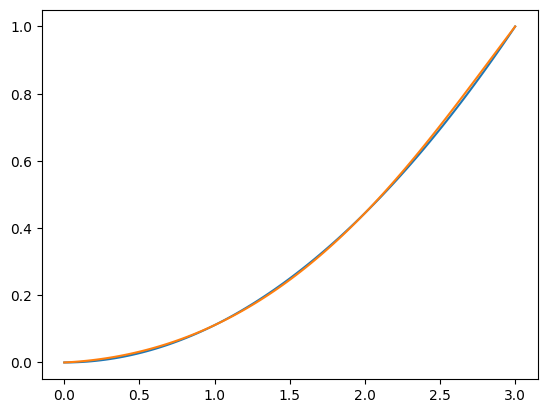

In [6]:
num_state_qubits_=2
epsilon_=0.05
degree_= 3
power =  2

c_star_ = (2*epsilon_)**(1/(degree_+1))
x_plot = np.linspace(0.0, 2**(num_state_qubits_) - 1, num=100)
x_eval = np.linspace(0.0, 2**(num_state_qubits_) - 1, num= degree_+1)
f_ = functools.partial(power_f, num_state_qubits=num_state_qubits_, power=power)


poly_ = arcsin_approx(f_, x_eval, epsilon_, degree_, c_star_)
def corrected_amplitudes(x):
    #return poly_(x)
    #return (np.sin(poly_(x))**2)
    return (((np.sin(poly_(x))**2) - 0.5) / c_star_) + 0.5

########

plt.plot(x_plot, f_(x_plot), label="f")
plt.plot(x_plot, corrected_amplitudes(x_plot), label=f"degree={degree_}")

## Polynomial Rotation Validation

<img src="../_common/images/poly_exp.png"  height="700" width="800" />

FIG. 1: Quantum circuit realizing the mapping $$|x\rangle |0\rangle \rightarrow |x\rangle \big(
(\cos(ζ(x)/2)|0\rangle + \sin(ζ(x)/2)|1\rangle\big)$$ 

for $ζ(x) = ax^2 + bx + c$ and $x ∈ {0, 1, 2, 3}$. Exploiting $x = 2q_1 +q_0$ and $q^2_i = q_i$ leads
to $ζ(x) = (4a + 2b)q_1 + 4aq_0q_1 + (a + b)q_0 + c$, which can be
directly mapped to a circuit. $R_y$ denotes a Y-rotation.

In [7]:
# Test coefficient list in the increasing degree; i.e. [a, b, c, ... {z}] for a + b x + c x^2 ... {z} x^n
num_q = 2
coef_list = [3, 1, 1]
poly = Polynomial(coef_list)
print(poly.coef)

print(binary_expansion(num_q, poly))

[3. 1. 1.]
{(): 3.0, (0,): 2.0, (1,): 6.0, (0, 1): 4.0}


## State-prep Circuit Verification

In [8]:
def state_prep(qc, qr, target_dist, num_state_qubits):
    """
    Use controlled Ry gates to construct the superposition Sum \sqrt{p_i} |i>
    """
    r_probs = region_probs(target_dist, num_state_qubits)
    regions = r_probs.keys()
    r_norm = {}
    
    for r in regions:
        num_controls = len(r) - 1
        super_key = r[:num_controls]

        if super_key=='':
            r_norm[super_key] = 1
        elif super_key == '1':
            r_norm[super_key] = r_probs[super_key]
            r_norm['0'] = 1-r_probs[super_key]
        else:
            try:
                r_norm[super_key] = r_probs[super_key]
                
            except KeyError:
                r_norm[super_key] = r_norm[super_key[:num_controls-1]] - r_probs[super_key[:num_controls-1] + '1']
        
        
        norm = r_norm[super_key]
        p = 0
        if norm != 0:
            p = r_probs[r] / norm
        theta = -2*np.arcsin(np.sqrt(p))
        
        if r == '1':
            qc.append(ry(theta).on(qr[num_state_qubits-1]))
        else:
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.append(X.on(qr[num_state_qubits-1 - k]))
            
            controls = [qr[num_state_qubits-1 - i] for i in range(num_controls)]
            qc.append(ry(theta).controlled(num_controls=num_controls).on(*controls+[qr[num_state_qubits-1-num_controls]]))
            
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.append(X.on(qr[num_state_qubits-1 - k]))

In [9]:
num_q = 3
t_d = {'101': 0, '000': 0.25, '011': 0.125, '100': 0.125, '001': 0.0, '010': 0.25, '110': 0.125, '111': 0.125}
u_d = uniform_dist(num_q)
m_d = {'000': 0.5, '001': 0.25, '010':0.25}

# Change to whatever distribution you like
dist = t_d

qr = cirq.LineQubit.range(num_q)
qc_ = cirq.Circuit()

state_prep(qc_, qr, dist, num_state_qubits=num_q)
qc_.append(measure(*qr, key='result'))


backend = cirq.Simulator()
result = backend.run(qc_, repetitions=1000)
measurements = result.measurements['result']
counts = defaultdict(lambda: 0)
for row in measurements:
    counts["".join([str(x) for x in reversed(row)])] += 1
counts = dict(counts)
    
print(dist)
print(counts)
print('')
print(hellinger_fidelity(dist,counts))

{'101': 0, '000': 0.25, '011': 0.125, '100': 0.125, '001': 0.0, '010': 0.25, '110': 0.125, '111': 0.125}
{'011': 121, '100': 121, '010': 263, '111': 137, '110': 104, '000': 254}

0.9727462806971126


## F Circuit Verification

In [10]:
def f_on_objective(qc, qr, f, epsilon=0.05, degree=3):
    """
    Assume last qubit is the objective. Function f is evaluated on first n-1 qubits
    """
    num_state_qubits = len(qr) - 1
    c_star = (2*epsilon)**(1/(degree+1))
    
    f_ = functools.partial(f, num_state_qubits=num_state_qubits)
    zeta_ = functools.partial(zeta_from_f, func=f_, epsilon=epsilon, degree=degree, c=c_star)
    
    x_eval = np.linspace(0.0, 2**(num_state_qubits) - 1, num= degree+1)
    poly = Polynomial(polyfit(x_eval, zeta_(x_eval), degree))
    
    b_exp = binary_expansion(num_state_qubits, poly)
    
    for controls in b_exp.keys():
        theta = 2*b_exp[controls]
        controls = list(controls)
        if len(controls)==0:
            qc.append(ry(-theta).on(qr[num_state_qubits]))
        else:
            qc.append(ry(-theta).controlled(num_controls=len(controls)).on(*[qr[i] for i in controls]+[qr[num_state_qubits]]))

In [11]:
backend = cirq.Simulator()

num_state_qubits_=4
epsilon_ = 0.05
degree_= 3
power =  1
c_star_ = (2*epsilon_)**(1/(degree_+1))

f_ = functools.partial(power_f, power=power)

x_vals = list(range(2**num_state_qubits_))
y_vals = []
f_vals = f_(x_vals, num_state_qubits_)

for i in x_vals:
    qr_ = [cirq.GridQubit(i, 0) for i in range(num_state_qubits_+1)]
    qc_ = cirq.Circuit()
    
    b = bin(i)[2:].zfill(num_state_qubits_)[::-1]
    for q in range(len(b)):
        if b[q]=='1':
            qc_.append(X.on(qr_[q]))
            
    f_on_objective(qc_, qr_, f_, epsilon_, degree_)
    qc_.append(measure(*qr_, key='result'))

    result = backend.run(qc_, repetitions=1000)
    measurements = result.measurements['result']
    counts = defaultdict(lambda: 0)
    for row in measurements:
        counts["".join([str(x) for x in reversed(row)])] += 1
    counts = dict(counts)

    print(counts)
    key = '1'+b[::-1]
    try:
        print(i, '', b, '', counts[key]/1000)
        y_vals.append(counts[key]/1000)
    except KeyError:
        print(i, '', b, '', 0)
        y_vals.append(0)
    print(qc_)
        
y_corrected = []
for y in y_vals:
    y_corrected.append(((y - 0.5) / c_star_) + 0.5)

{'00000': 753, '10000': 247}
0  0000  0.247
(0, 0): ────────────────@───────────────────────────────────────────────────────@────────────@────────────@───────────────────────────────────────────────────@─────────────@─────────────@──────────────────────────M('result')───
                        │                                                       │            │            │                                                   │             │             │                          │
(1, 0): ────────────────┼─────────────@─────────────────────────────────────────@────────────┼────────────┼────────────@────────────@─────────────────────────@─────────────@─────────────┼─────────────@────────────M─────────────
                        │             │                                         │            │            │            │            │                         │             │             │             │            │
(2, 0): ────────────────┼─────────────┼─────────────@─────────────────

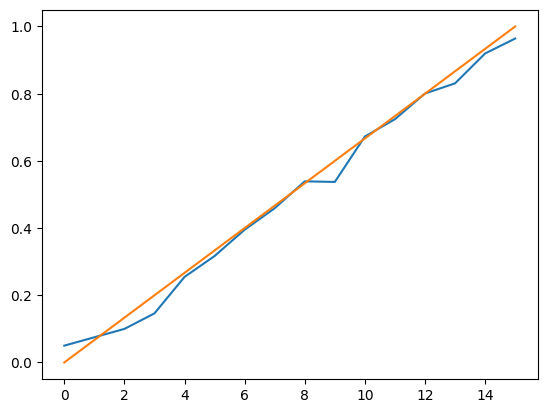

In [12]:
#plt.plot(x_vals, y_vals)
plt.plot(x_vals, y_corrected)
plt.plot(x_vals, f_vals)
print('')
plt.show()

## All together

In [13]:
dist = u_d
print(u_d)

{'000': 0.125, '001': 0.125, '010': 0.125, '011': 0.125, '100': 0.125, '101': 0.125, '110': 0.125, '111': 0.125}


In [14]:
def actual_(dist, f_, num_state_qubits):
    s = 0
    _f = functools.partial(f_, num_state_qubits=num_state_qubits)
    for key in dist.keys():
        x = int(key,2)
        s += dist[key]*_f(x)
    return s

In [15]:
def AE_Subroutine(num_state_qubits, num_ancillas, A_circuit):
    qr_state = cirq.GridQubit.rect(1,num_state_qubits+1,0)
    qr_ancilla = cirq.GridQubit.rect(1,num_ancillas,1)
    qc_full = cirq.Circuit()

    A = to_gate(num_state_qubits+1, A_circuit, name="A")
    cQ, Q = Ctrl_Q(num_state_qubits, A_circuit)

    # Prepare state from A, and ancillas with H transform
    qc_full.append(A.on(*qr_state))
    for i in range(num_ancillas):
        qc_full.append(cirq.H.on(qr_ancilla[i]))
    
    repeat = 1
    for j in reversed(range(num_ancillas)):
        for _ in range(repeat):
            qc_full.append(cQ.on(*[qr_ancilla[j]]+qr_state))
        repeat *= 2

    # inverse quantum Fourier transform only on ancillas
    QFT_inv_circ = inv_qft_gate(num_ancillas)
    #QFT_inv_circ = inv_qft_gate(cirq.Circuit(), cirq.GridQubit.rect(1,num_ancillas,1), num_ancillas)
    QFT_inv_gate = to_gate(num_ancillas, QFT_inv_circ, name="QFT^-1")
    qc_full.append(QFT_inv_gate.on(*qr_ancilla))

    qc_full.append(cirq.measure(*qr_ancilla, key='result'))

    return qc_full

In [16]:
def MonteCarloSampling(target_dist, f, num_state_qubits, num_ancillas, epsilon=0.05, degree=2):
    
    A_qr = cirq.LineQubit.range(num_state_qubits_+1)
    A = cirq.Circuit()
    
    state_prep(A, A_qr, target_dist, num_state_qubits)
    f_on_objective(A, A_qr, f, epsilon=epsilon, degree=degree)
    
    qc = AE_Subroutine(num_state_qubits, num_ancillas, A)
    
    return qc 

In [17]:
# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qr_Q = cirq.GridQubit.rect(1,num_state_qubits+1,0)
    qc_Q = cirq.Circuit()
    
    A_gate = to_gate(num_state_qubits+1, A_circ, name="A")
    A_gate_inv = cirq.inverse(copy.copy(A_gate))
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc_Q.append(cirq.X(qr_Q[num_state_qubits]))
    qc_Q.append(cirq.Z(qr_Q[num_state_qubits]))
    qc_Q.append(cirq.X(qr_Q[num_state_qubits]))
        
    # A_circ_inverse
    qc_Q.append(A_gate_inv.on(*qr_Q))
        
    # S_0
    for i in range(num_state_qubits+1):
        qc_Q.append(cirq.X.on(qr_Q[i]))
    qc_Q.append(cirq.H(qr_Q[num_state_qubits]))
    
    qc_Q.append(cirq.X.controlled(num_controls=num_state_qubits).on(*qr_Q))
    
    qc_Q.append(cirq.H(qr_Q[num_state_qubits]))
    for i in range(num_state_qubits+1):
        qc_Q.append(cirq.X.on(qr_Q[i]))
        
    # A_circ
    qc_Q.append(A_gate.on(*qr_Q))
    
    # Create a gate out of the Q operator
    Q_ = to_gate(num_qubits=num_state_qubits+1, circ=qc_Q, name="Q")
    
    # and also a controlled version of it
    Ctrl_Q_ = cirq.ops.ControlledGate(Q_, num_controls=1)
    
    # and return both
    return Ctrl_Q_, Q_

In [18]:
class to_gate(cirq.Gate):
    def __init__(self, num_qubits, circ, name="G"):
        self.num_qubits=num_qubits
        self.circ = circ
        self.name = name
        
    def _num_qubits_(self):
        return self.num_qubits
    
    def _decompose_(self, qubits):
        # `sorted()` needed to correct error in `all_qubits()` not returning a reasonable order for all of the qubits
        qbs = sorted(list(self.circ.all_qubits()))
        mapping = {}
        for t in range(self.num_qubits):
            mapping[qbs[t]] = qubits[t]
        def f_map(q):
            return mapping[q]
        
        circ_new = self.circ.transform_qubits(f_map)
        return circ_new.all_operations()
    
    def _circuit_diagram_info_(self, args):
        return [self.name] * self._num_qubits_()

In [19]:
num_state_qubits_= 3
num_ancillas = 6
epsilon_=0.05
degree_= 2
power =  2
c_star_ = (2*epsilon_)**(1/(degree_+1))

p = uniform_dist
dist = p(num_state_qubits_)

f_ = functools.partial(power_f, power=power)

qc_ = MonteCarloSampling(dist, f_, num_state_qubits_, num_ancillas, epsilon_, degree_)

backend = cirq.Simulator()
result = backend.run(qc_, repetitions=1000)
measurements = result.measurements['result']
counts = defaultdict(lambda: 0)
for row in measurements:
    counts["".join([str(x) for x in reversed(row)])] += 1
counts = dict(counts)

v_string = max(counts, key=counts.get)
v = int(v_string,2)
#print(v, v_string)

a = pow(np.sin(np.pi*v/pow(2,num_ancillas)),2)
a_est = ((a - 0.5)/c_star_) + 0.5

a_exact = actual_(dist, f_, num_state_qubits_)

print(a_est, a_exact)

AttributeError: 'to_gate' object has no attribute 'all_qubits'

In [20]:
best_result = max(counts, key=counts.get)
v = int(best_result,2)
print(v, best_result)
    
#a_ = pow(np.sin(2*np.pi*v/pow(2,num_ancillas)),2)
#a_est = a_ 

best_result = max(counts, key=counts.get)
v = int(best_result,2)
a_int = pow(np.sin(np.pi*v/pow(2,num_ancillas)),2)
a_est = ((a_int - 0.5) / c_star_) + 0.5

a_exact = actual_(dist,f_,num_state_qubits_)
a_ex = ((a_exact - 0.5) * c_star_) + 0.5

print(a_est, a_exact)
print(a_int, a_ex)
print(counts)

31 11111
1.5720302490662397 0.35714285714285715
0.9975923633360985 0.433691588091246
{'11111': 761, '01111': 239}


Monte Carlo Sampling Benchmark Program - Cirq
... using circuit method 2
... execution starting at Dec 11, 2023 07:29:31 UTC
************
Executing [1] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.004, 0.007, 0.007 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 0.0, 0.0

************
Executing [1] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.003, 0.012, 0.012 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 0.0, 0.0

************
Executing [1] circuits with num_qubits = 6
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.005, 0.024, 0.024 secs
Average Hellinger, Normalized Fidelity for the 6 qubit group = 0.0, 0.0

************
Executing [1] circuits with num_qubits = 7
Average Creation, Elapsed, Execution Time for the 7 qubit group = 0.008, 0.045, 0.045 secs
Average Hellinger, Normalized Fidelity for the 7 qubit group = 0.0, 

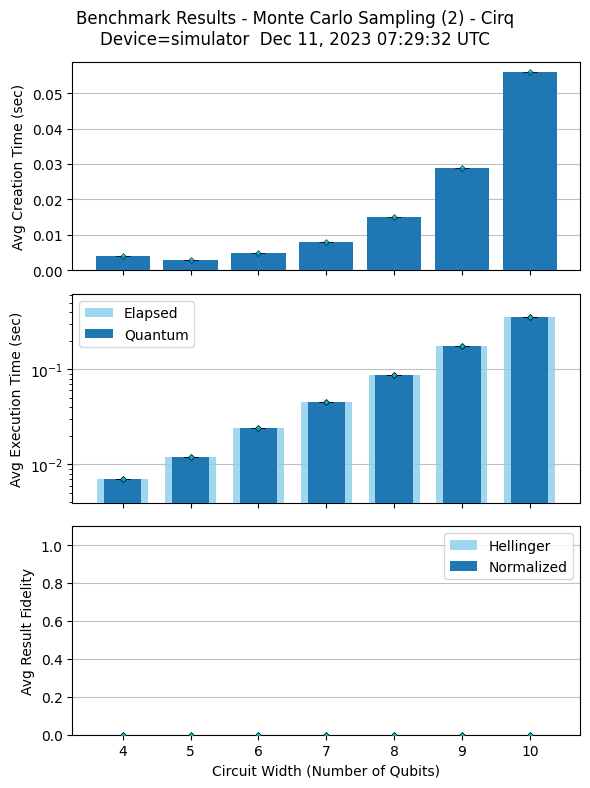

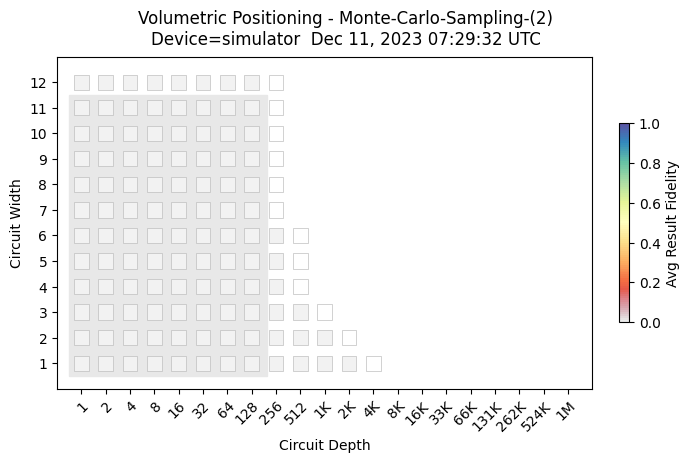

In [21]:
%run mc_benchmark.py